In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pickle
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import auc
from scipy import interp

In [28]:
def evaluate_performance(observed, predicted):
    accuracy = sklearn.metrics.accuracy_score(observed, predicted)
    precision = sklearn.metrics.precision_score(observed, predicted)
    recall = sklearn.metrics.recall_score(observed, predicted)
    f1 = sklearn.metrics.f1_score(observed, predicted)
    mcc = sklearn.metrics.matthews_corrcoef(observed, predicted, sample_weight=None)
    auc = sklearn.metrics.roc_auc_score(observed, predicted)
    return({'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1':f1, 'MCC':mcc, 'AUC':auc})

In [29]:
chunks = np.concatenate([np.load('embedding_chunks/'+chunk) for chunk in os.listdir('embedding_chunks')], axis = 0)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(chunks[:, 1:], (chunks[:, 0] > 0).astype(int), test_size=0.2, random_state=40)

In [33]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(C=.3, penalty='l2', solver='newton-cg', 
                                                 multi_class='multinomial', n_jobs=-1, random_state=13))
cv_scores = cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=5)

array([0.688771  , 0.67866296, 0.68063703, 0.6906731 , 0.68982169])

In [34]:
np.mean(cv_scores)

0.6857131559350927

In [36]:
sm = SMOTE(random_state=42)
X_train_upsample, y_train_upsample = sm.fit_resample(X_train, y_train)
logreg = LogisticRegression(C=.3, penalty='l2', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=13)
logreg.fit(X_train_upsample, y_train_upsample)
y_pred = logreg.predict(X_test)
evaluate_performance(y_test, y_pred)

{'Accuracy': 0.6846941454449987,
 'Precision': 0.2635239567233385,
 'Recall': 0.5789473684210527,
 'F1': 0.36218799787573025,
 'MCC': 0.21602912508569647,
 'AUC': 0.6414923177508989}

In [40]:
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)

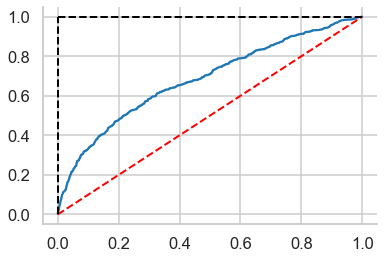

In [46]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.lineplot(x=fpr, y=tpr)
sns.despine()
plt.plot([0, 1], [0, 1], linewidth=2, linestyle='--', color='red')
plt.plot([0, 0], [0, 1], linewidth=2, linestyle='--', color='black')
plt.plot([0, 1], [1, 1], linewidth=2, linestyle='--', color='black')

In [48]:
#Train the model on all available data for pickling
X = chunks[:, 1:]
y = chunks[:, 0] > 0
X_train_upsample, y_train_upsample = sm.fit_resample(X, y)
logreg_full = LogisticRegression(C=.3, penalty='l2', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=13)
logreg_full.fit(X_train_upsample, y_train_upsample)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=-1, penalty='l2',
                   random_state=13, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
filename = 'trained_model.sav'
pickle.dump(logreg_full, open(filename, 'wb'))